# Introduction to LangGraph - Module 3: UX and Human-in-the-Loop

# Pre-requisites

In [1]:
!pip install -qU langgraph langgraph_sdk langchain_openai langchain_core langgraph-prebuilt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 12.1 MB/s eta 0:00:00


# Streaming

In Module 2, we built a Chatbot with external memory that can sustain long-running conversations.

In this section, we will use `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs.

To apply `human-in-the-loop`, we need to set up streaming first, which provides several ways to visualize graph output (e.g., node state or chat model tokens).

In [ ]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

We will set up our chatbot from Module 2.

We will use `RunnableConfig` with `call_model` to enable token-wise streaming. This is only needed with Python < 3.11

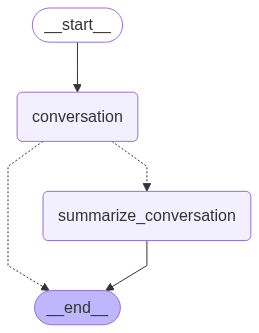

In [ ]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState


# LLM
model = ChatOpenAI(model='gpt-4o', temperature=0)

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    # Get summary if it exists
    summary = state.get('summary', '')

    # If there is summary, then we add it
    if summary:
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state['messages']
    else:
        messages = state['messages']

    response = model.invoke(messages, config)

    return {'messages': response}


def summarize_conversation(state: State):
    # 1. Get any existing summary
    summary = state.get('summary', '')

    # 2. Create summarization prompt
    if summary:
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # 3. Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # 4. Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


# Determine whether to end or summarize the conversation
def should_continue(state: State):
    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END


# Build
builder = StateGraph(State)
builder.add_node('conversation', call_model)
builder.add_node('summarize_conversation', summarize_conversation)

# Logic
builder.add_edge(START, 'conversation')
builder.add_conditional_edges(
    'conversation',
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        END: END
    }
)
builder.add_edge('summarize_conversation', END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

## Streaming full state

In LangGraph, there are two methods for streaming: `.stream` and `.astream` are sync and async methods for streaming back results.

LangGraph supports a few different streaming modes for graph state:
- `values` streams the full state of the graph after each node is called.
- `updates` streams updates to the state of the graph after each node is called.

For `stream_mode="updates"`, we only see updates to the state after node in the graph is run. Each `chunk` is a dictionary with `node_name` as the key and the updated state as the value.

In [ ]:
config = {
    'configurable': {'thread_id': '1'}
}

# Start a conversation
for chunk in graph.stream({'messages': [HumanMessage(content="Hi! I'm Bin.")]}, config, stream_mode='updates'):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello, Bin! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 12, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C5vZ0zUnA6nkLtg1Q5KTExp4zcTgu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f2cdca54-b926-4fa3-bf86-926dba704c6d-0', usage_metadata={'input_tokens': 12, 'output_tokens': 11, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


Basically only returned message is displayed:

In [ ]:
for chunk in graph.stream({"messages": [HumanMessage(content="Hi! I'm Bin.")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi again, Bin! How can I help you today?


For `stream_node="values"`, the full state is displayed after the `conversation` node is called:

In [ ]:
config = {
    "configurable": {"thread_id": "2"}
}

# Start conversation
input_message = HumanMessage(content="Hi! I'm Bin.")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("+-+-"*25)

================================ Human Message =================================

Hi! I'm Bin.
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
================================ Human Message =================================

Hi! I'm Bin.
================================== Ai Message ==================================

Hello, Bin! How can I assist you today?
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-


## Streaming tokens

With chat model calls, it is common to stream the tokens as they are generated.

We can use `.astream_events` method which streams back events as they happen inside nodes.

Each event is a dictionary with a few key:
- `event`: Type of the event that is being emitted
- `name`: Name of the event
- `data`: Data associated with the event
- `metadata`: `langgraph_node`, the node emitting the event.

In [ ]:
config = {
    'configurable': {'thread_id': '3'}
}

input_message = HumanMessage(content='Tell me about the Golden State Warriors')

async for event in graph.astream_events({'messages': input_message}, config, version='v2'):
    print(f"Node: {event['metadata'].get('langgraph_node', '')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

Note that tokens from chat models within our graph have the `on_chat_model_stream` type.

Now we can use `event['metadata']['langgraph_node']` to select the node to stream from. In addition, we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`.

In [ ]:
node_to_stream = 'conversation'
config = {
    'configurable': {'thread_id': '4'}
}

input_message = HumanMessage(content='Tell me about the Golden State Warriors')

async for event in graph.astream_events({'messages': input_message}, config, version='v2'):
    # Get chat model tokens from a particular node
    if event['event'] == 'on_chat_model_stream' and event['metadata'].get('langgraph_node', '') == node_to_stream:
        print(event['data'])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--a17ce015-3545-4f43-82a7-ca9cc4621392')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--a17ce015-3545-4f43-82a7-ca9cc4621392')}
{'chunk': AIMessageChunk(content=' Golden', additional_kwargs={}, response_metadata={}, id='run--a17ce015-3545-4f43-82a7-ca9cc4621392')}
{'chunk': AIMessageChunk(content=' State', additional_kwargs={}, response_metadata={}, id='run--a17ce015-3545-4f43-82a7-ca9cc4621392')}
{'chunk': AIMessageChunk(content=' Warriors', additional_kwargs={}, response_metadata={}, id='run--a17ce015-3545-4f43-82a7-ca9cc4621392')}
{'chunk': AIMessageChunk(content=' are', additional_kwargs={}, response_metadata={}, id='run--a17ce015-3545-4f43-82a7-ca9cc4621392')}
{'chunk': AIMessageChunk(content=' a', additional_kwargs={}, response_metadata={}, id='run--a17ce015-3545-4f43-82a7-ca9cc4621392')}
{'chunk': AIMessageChunk(content=' professional', additiona

Now we can just use the `chunk` key to get the `AIMessageChunk`:

In [ ]:
node_to_stream = 'conversation'
config = {
    'configurable': {'thread_id': '5'}
}

input_message = HumanMessage(content='Tell me about the Golden State Warriors')

async for event in graph.astream_events({'messages': input_message}, config, version='v2'):
    # Get chat model tokens from a particular node
    if event['event'] == 'on_chat_model_stream' and event['metadata'].get('langgraph_node', '') == node_to_stream:
        data = event['data']
        print(data['chunk'].content, end='|')

|The| Golden| State| Warriors| are| a| professional| basketball| team| based| in| San| Francisco|,| California|.| They| are| a| member| of| the| Western| Conference|'s| Pacific| Division| in| the| National| Basketball| Association| (|NBA|).| The| team| was| founded| in| |194|6| as| the| Philadelphia| Warriors|,| based| in| Philadelphia|,| Pennsylvania|,| and| was| one| of| the| original| teams| in| the| Basketball| Association| of| America| (|BA|A|),| which| later| merged| with| the| National| Basketball| League| (|N|BL|)| to| form| the| NBA|.

|###| Key| Points| about| the| Golden| State| Warriors|:

|1|.| **|Champ|ionship|s| and| Success|:|**
|  | -| The| Warriors| have| won| multiple| NBA| championships|,| with| their| most| successful| periods| being| in| the| |197|0|s| and| the| |201|0|s|.| 
|  | -| They| won| their| first| championship| in| |194|7| and| have| since| added| several| more|,| including| titles| in| |195|6|,| |197|5|,| |201|5|,| |201|7|,| |201|8|,| and| |202|2|.

|2|

## Streaming with LangGraph API

Once we set up and run our graph in the local LangGraph Studio, we can use the LangGraph API to edit the graph state.

In [ ]:
# Assume the graph is hosted and running on http://127.0.0.1:2024

from langgraph_sdk import get_client

# This is the URL of the local dev server
URL = 'http://127.0.0.1:2024'

client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Then we can select a graph and stream values like before:

In [ ]:
# Create a thread
thread = await client.threads.create()

# Prepare input message
input_message = HumanMessage(content="Multiply 2 and 3")

async for event in client.runs.stream(
    thread['thread_id'],
    assistant_id='agent',
    input={'messages': input_message},
    stream_mode='values'
):
    print(event)

The streamed objects have:
- `event`: Type
- `data`: State

Now we can run that thread again and clean up the output:

In [ ]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

async for event in client.runs.stream(
    thread['thread_id'],
    assistant_id='agent',
    input={'messages': input_message},
    stream_mode='values'
):
    messages = event.data.get('messages', None)

    if messages:
        print(convert_to_messages(messages)[-1])

    print('='*25)

Some new streaming mode that are only supported via the API. For example, we can use `messages` mode to better handle the above case.

This mode assumes that we have a `messages` key in our graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:
- `event`: Name of the event
- `data`: Data associated with the event

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": input_message},
    stream_mode="messages", # message streaming mode
):
    print(event.event)

Note the event names:
- `metadata`: metadata about this run
- `messages/complete`: fully formed message
- `messages/partial`: chat model tokens


To stream these messages, we need to define a helper function for better formatting of the tool calls in messages.

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

In [ ]:
# tool call helper
def format_tool_calls(tool_calls):
    """Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A string representing the formatted tool calls, or 'No tool calls' if the list is empty.
    """
    if tool_calls:
        formatted_calls = []

        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )

        return '\n'.join(formatted_calls)
    return 'No tool calls'

In [ ]:
# Streaming
async for event in client.runs.stream(
    thread['thread_id'],
    assistant_id='agent',
    input={'messages': input_message},
    stream_mode='messages'
):
    # Handle metadata events
    if event.event == 'metadata':
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print('-'*50)

    # Handle partial message events
    elif event.event == 'messages/partial':
        for data_item in event.data:
            # Process user messages
            if 'role' in data_item and data_item['role'] == 'user':
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event (non-user event)
                tool_calls = data_item.get('tool_calls', [])
                invalid_tool_calls = data_item.get('invalid_tool_calls', [])
                content = data_item.get('content', '')
                response_metadata = data_item.get('response_metadata', {})


                # Formatted prints
                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get('finish_reason', 'N/A')
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print('-'*50)

# Breakpoints

Streaming allows us to emit graph state at every step, and this sets up human-in-the-loop.

Use cases for human-in-the-loop:
1. **Approval**: We can interrupt our agent, surface state to a user, and allow the user to accept an action, such as tool usage confirmation.
2. **Debugging**: We can rewind the graph to reproduce or avoid issues.
3. **Editing**: We can modify the state directly.


**Breakpoints** provide a simple way to stop the graph at specific steps.


In [ ]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

## Breakpoints for human approval

We will reuse the simple agent we built in Module 1. Assume that we are concerned about tool use and we want to approve the agent to use any of its tools.

To achieve this, we will compile the graph with `interrupt_before=['tools']` where `tools` is our tools node. This means that the execution will be interrupted before the node `tools`, which executes the tool call.

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model='gpt-4o', temperature=0)
llm_with_tools = llm.bind_tools(tools)

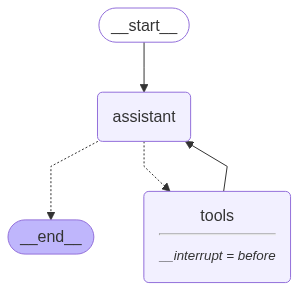

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
    response = llm_with_tools.invoke([sys_msg] + state['messages'])
    return {'messages': response}

# Graph
builder = StateGraph(MessagesState)

# Nodes
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

# Edges
builder.add_edge(START, 'assistant')
builder.add_conditional_edges(
    'assistant',
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge('tools', 'assistant') # routes back to assistant after tool calls

# Compile
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    interrupt_before=['tools'], # add breakpoint
)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(
    initial_input,          # query
    thread,                 # thread for memory
    stream_mode="values"    # streaming mode
):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YCxKuBqRlTuMNNOeU86AA88s)
 Call ID: call_YCxKuBqRlTuMNNOeU86AA88s
  Args:
    a: 2
    b: 3


We see that the graph execution stops at the `tools` node before node execution. We can get the state and check the next node to call:

In [ ]:
state = graph.get_state(thread)
state.next

('tools',)

To continue from the last state checkpoint, we just need to invoke the graph with `None`:



In [ ]:
for event in graph.stream(
    None,                   # query to continue
    thread,                 # thread for memory
    stream_mode="values"    # streaming mode
):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_YCxKuBqRlTuMNNOeU86AA88s)
 Call ID: call_YCxKuBqRlTuMNNOeU86AA88s
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


LangGraph will re-emit the current state, which contains the `AIMessage` with tool call, and then it will proceed to execute the following steps in the graph, which start with the tool node.

Now we see that the tool node is run with this tool call, and it is passed back to the chat model for our final answer.

Next, we can bring these together with a specific user approval step that accepts user input:

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(
    initial_input,
    thread,
    stream_mode="values"
):
    event['messages'][-1].pretty_print()


# Get user feedback
user_approval = input("Do you want to call the tools? (yes/no): ")

# Check approval
if user_approval.lower() == 'yes':

    # If approved, continue to graph execution
    for event in graph.stream(
        None,
        thread,
        stream_mode='values'
    ):
        event['messages'][-1].pretty_print()
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_W9xJxJtUc6S8DWBDl8mA5l2D)
 Call ID: call_W9xJxJtUc6S8DWBDl8mA5l2D
  Args:
    a: 2
    b: 3
Do you want to call the tools? (yes/no): yes
================================== Ai Message ==================================
Tool Calls:
  multiply (call_W9xJxJtUc6S8DWBDl8mA5l2D)
 Call ID: call_W9xJxJtUc6S8DWBDl8mA5l2D
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Breakpoints with LangGraph API

Assume our agent is running and hosted on `http://127.0.0.1:2024`

In [ ]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

As shown above, we can add `interrupt_before=['node']` when compiling the graph that is running in Studio. However, with the API, we can also pass `interrupt_before` to the stream method directly:

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = await client.threads.create()

async for chunk in client.runs.stream(
    thread['thread_id'],
    assistant_id='agent',
    input=initial_input,
    stream_mode='values',
    interrupt_before=['tools']
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Now we can proceed from the breakpoint just like we did before by passing the `thread_id` and `None` as the input:

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

To add breakpoint in the `graph` object in the agent script, we just need to change `graph = builder.compile()` by
```python
graph = builder.compile(interrupt_before=['tools'])
```
and then restart the API.


Therefore, via the LangGraph Studio API, we can add breakpoints in two places:
- `builder.compile()` with `interrupt_before` argument, or
- `client.runs.stream()` with `interrupt_before` arugment.

# Editing Graph State

In the previous section, we applied breakpoints to stop the graph execution at specific nodes and support user approval.

In this section, we will directly edit the graph state and insert human feedback.

In [2]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

## Editing state

When we use breakpoints to interrupt the graph and await user approval before executing the next node, we have a chance to modify the graph state.

Assume that we set up our agent with a breakpoint before the `assistant` node.

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

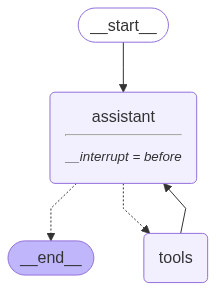

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Nodes
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

# Edges
builder.add_edge(START, 'assistant')
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge('tools', 'assistant') # routes back to assistant after tool calls

# Compile
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    interrupt_before=['assistant'], # instead of tools node, we will interrupt before `assistant` node
)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


We can see that the graph is interrupted before the chat model responds.

In [6]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b36b5874-21ec-4374-aaa1-f0a41b825d66')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07d375-04f7-6dac-8000-01f23e6d6e34'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-19T20:01:37.254510+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07d375-04f3-614f-bfff-3a64858774a2'}}, tasks=(PregelTask(id='dba50419-efe8-8d93-f72b-7bf3552a21bf', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now we can directly apply a state update.

Recall that any updates to the `messages` key will use the `add_messages` reducer:
- If we want to overwrite the existing message, we can supply the message `id`.
- If we simply want to append to our list of messages, then we can pass a message without an `id` specified.

In [7]:
# Here we did not give the `message` id, so this message is appended to the last message
graph.update_state(
    thread,
    {'messages': [HumanMessage(content="No, actually multiply 3 and 3!")]}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07d37d-73c8-6ba8-8001-b31edf2b8f8b'}}

We called `update_state` with a new message. The `add_messages` reducer appends it to our state key, `messages`:

In [8]:
new_state = graph.get_state(thread).values

for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


We can see that there are two `HumanMessage` objects in our new updated state.

Now we can proceed with our agent by passing `None` and allowing it proceed from the current state. We emit the current and then proceed to execute the remaning nodes.

In [9]:
for event in graph.stream(
    None,                    # proceed to next node
    thread,                  # thread for memory
    stream_mode='values',    # streaming mode
):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_aG7W2f7r25jy0ahKCAJC0Aws)
 Call ID: call_aG7W2f7r25jy0ahKCAJC0Aws
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


Now, after the tool call, we are back at the `assistant` node, which has our breakpoint. We can again pass the `None` to proceed:

In [10]:
for event in graph.stream(
    None,                    # proceed to next node
    thread,                  # thread for memory
    stream_mode='values',    # streaming mode
):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 by 3 is 9.


## Editing graph state in Studio

Assume our agent is running and hosted at http://127.0.0.1:2024

In [ ]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

When writing an agent script using LangGraph API, we usually do not set breakpoints in the script. Of course we still can, but the API allows us to pass in a breakpoint without modifying the agent graph builder.

Here, we can pass a `interrupt_before=['assistant']`:

In [ ]:
initial_input = {'messages': 'Multiply 2 and 3'}
thread = await client.threads.create()

async for chunk in client.runs.stream(
    thread['thread_id'],
    'agent',
    input=initial_input,
    stream_mode='values',
    interrupt_before=['assistant']
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

In [ ]:
# Get the current state
current_state = await client.threads.get_state(thread['thread_id'])
current_state

In [ ]:
# Get the last message in that state
last_message = current_state['values']['messages'][-1]
last_message

In [ ]:
# Edit that directly
last_message['content'] = "No, actually multiply 3 and 3!"
last_message

NOTE: updates to the `messages` key will use the same `add_messages` reducer. If we want to overwrite the existing message, then we can supply the message `id`. Here, we did overwrite the existing message because the `last_message` object has a `id` property saved in its dictionary when we pass `last_message` to the `update_state` method. We only modified the message `content`, as shown above:

In [ ]:
await client.threads.update_state(
    thread['thread_id'],
    {'messages': last_message}
)

In [ ]:
# Proceed by passing `None`
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

In [ ]:
# Proceed again to complete the graph execution
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

## Awaiting user input

In this section, we will allow the agent for human feedback to perform a state update. We will add a node that serves as a placeholder for human feedback within our agent.

The `human_feedback` node allow the user to add feedback directly to state. We will specify the breakpoint using `interrupt_before` in our `human_feedback` node. We also set up a checkpointer to save the state of the graph up until this node.

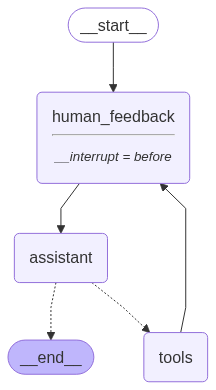

In [11]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# No-operation node that should be interrupted on
def human_feedback(state: MessagesState):
    pass


# Assistant node
def assistant(state: MessagesState):
    response = llm_with_tools.invoke([sys_msg] + state['messages'])
    return {'messages': response}



# Builder
builder = StateGraph(MessagesState)

# Nodes
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))
builder.add_node('human_feedback', human_feedback)

# Edges
builder.add_edge(START, 'human_feedback')
builder.add_edge('human_feedback', 'assistant')
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge('tools', 'human_feedback')

# Compile
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    interrupt_before=['human_feedback']
)

display(Image(graph.get_graph().draw_mermaid_png()))

In this graph, we will get feedback from the user. We can use `update_state` method to update the state of the graph with the human response we get. In addition, we use the `as_node='human_feedback'` parameter to apply this state update as the specified node, `human_feedback`:

In [12]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


# Get user input
user_input = input("Tell me how you want to update the state: ")

# Update the state as if we are the `human_feedback` node
graph.update_state(
    thread,
    {'messages': user_input},
    as_node='human_feedback'   # As if the `human_feedback` ran in the graph
)

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
Tell me how you want to update the state: nah, multiply 4 and 7
================================ Human Message =================================

nah, multiply 4 and 7
================================== Ai Message ==================================

Let's multiply 4 and 7.
Tool Calls:
  multiply (call_TpgaEiDijyGIVPcy2o4UVE7k)
 Call ID: call_TpgaEiDijyGIVPcy2o4UVE7k
  Args:
    a: 4
    b: 7
================================= Tool Message =================================
Name: multiply

28


In [13]:
# Continue the graph execution to the end
for event in graph.stream(None, thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

28
================================== Ai Message ==================================

The result of multiplying 4 and 7 is 28.


This is how we use a dummy node (`human_feedback` node in this case) to inject human feedback in our agent graph.

We basically add feedback as if that node is running

# Dynamic Breakpoints

Breakpoints are set by the developer on a specific node during graph compilation. Sometimes it is helpful to allow the graph *dynamically interrupt* itself. This is called an **internal breakpoint**, and can be achieved using `NodeInterrupt`.

This has a few specific benefits:
1. We can do it conditionally (from inside a node based on developer-defined logic).
2. We can communicate to the user why its interrupted (by passing whatever we want to the `NodeInterrupt`).

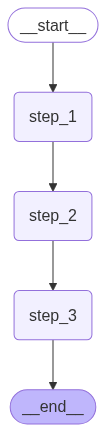

In [19]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
# New
from langgraph.errors import NodeInterrupt


class State(TypedDict):
    input: str


def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Now let's run a graph with an input that is longer than 5 characters:

In [20]:
initial_input = {'input': 'hello world!'}
thread = {'configurable': {'thread_id': '1'}}

# Run the graph
for event in graph.stream(initial_input, thread, stream_mode='values'):
    print(event)

{'input': 'hello world!'}
---Step 1---
{'input': 'hello world!'}


/tmp/ipython-input-1659169691.py:21: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [21]:
state = graph.get_state(thread)
state.next

('step_2',)

We see that the node set to execute `step_2` as the next node. We also see that the `Interrupt` is logged to state:

In [22]:
state.tasks

(PregelTask(id='1f348094-2432-9e22-7f77-1bacc779e6ab', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world!', id='placeholder-id'),), state=None, result=None),)

We can try to resume the graph from the breakpoint, but this just re-runs the same node. Unless we change the state, we will be struck here:

In [24]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'input': 'hello world!'}


/tmp/ipython-input-1659169691.py:21: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [25]:
state = graph.get_state(thread)
print(state.next)

('step_2',)


To get rid of this loop, we need to update our current state with less than 5 characters:

In [26]:
graph.update_state(
    thread,
    {'input': 'hi'}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07d45b-fcc5-678a-8002-37c8f6a1ad04'}}

In [27]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


## LangGraph API

Assume our agent is hosted at http://127.0.0.1:2024

In [ ]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [ ]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):

    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state['next']

In [ ]:
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):

    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

# Time Travel

LangGraph supports debugging by viewing, re-playing and even forking from past states. This is collectively called **time travel**.

In [28]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

Still using our simple agent:

In [29]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

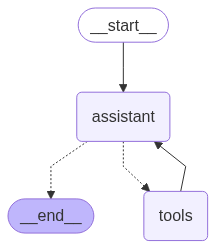

In [30]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [31]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_odOMRV70EL836bgasms3Y1QP)
 Call ID: call_odOMRV70EL836bgasms3Y1QP
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing history

We can use `get_state` to look at the *current state* of our graph, given the `thread_id`:

In [32]:
graph.get_state(
    {'configurable': {'thread_id': '1'}}
)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='774d6d1a-226f-4640-b7e5-b0b2381ccaaf'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_odOMRV70EL836bgasms3Y1QP', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C6OVjd1Xtaa1nOeOpgcYfevpi1YcT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cd5e0d6d-ba51-407e-90a6-cd869f13537b-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_odOMRV7

We can also browse the state history of our agent by using `get_state_history` to get the state at all prior steps:

In [33]:
all_states = [
    s for s in graph.get_state_history(
        {'configurable': {'thread_id': '1'}}
    )
]

len(all_states)

5

The first element is the current state, just as we got from `get_state`:

In [34]:
all_states[0]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='774d6d1a-226f-4640-b7e5-b0b2381ccaaf'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_odOMRV70EL836bgasms3Y1QP', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C6OVjd1Xtaa1nOeOpgcYfevpi1YcT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cd5e0d6d-ba51-407e-90a6-cd869f13537b-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_odOMRV7

In [35]:
all_states[1]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='774d6d1a-226f-4640-b7e5-b0b2381ccaaf'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_odOMRV70EL836bgasms3Y1QP', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C6OVjd1Xtaa1nOeOpgcYfevpi1YcT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cd5e0d6d-ba51-407e-90a6-cd869f13537b-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_odOMRV7

## Replaying

We can re-run our agent from any of the prior steps:

In [36]:
to_replay = all_states[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='774d6d1a-226f-4640-b7e5-b0b2381ccaaf')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07d468-1fdd-6dd3-8000-6c8b8c85fd8b'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-19T21:50:23.056598+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07d468-1fd6-6052-bfff-270e5722bb3f'}}, tasks=(PregelTask(id='291ce926-4d29-ad09-385f-2faf5a2e9538', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_odOMRV70EL836bgasms3Y1QP', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 

In [37]:
# Check the state
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='774d6d1a-226f-4640-b7e5-b0b2381ccaaf')]}

In [38]:
# next node to call
to_replay.next

('assistant',)

We can also get the config, which tells us the `checkpoint_id` and the `thread_id`:

In [39]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07d468-1fdd-6dd3-8000-6c8b8c85fd8b'}}

To replay from this state, we just pass the config back to the agent. The graph knows that this checkpoint has already been executed. It will just replay from this checkpoint:

In [40]:
for event in graph.stream(
    None,
    to_replay.config,
    stream_mode='values'
):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_hXSmmlQ7P9v1t5Yn3n4JvC4Y)
 Call ID: call_hXSmmlQ7P9v1t5Yn3n4JvC4Y
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Forking

Forking allows us to run from the same step in a graph with a different input.

In [41]:
to_fork = all_states[-2]
to_fork.values['messages']

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='774d6d1a-226f-4640-b7e5-b0b2381ccaaf')]

In [42]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07d468-1fdd-6dd3-8000-6c8b8c85fd8b'}}

Now we can modify this state at this checkpoint. We can run `update_state` with the `checkpoint_id` supplied.

Recall how our `add_messages` reducer works:
- If we supply a message ID, it will overwrite that message
- If not, it will append the message.

Hence, to overwrite the message, we need to supply the message ID, which we have `to_fork.values['messages'].id`:

In [43]:
fork_config = graph.update_state(
    to_fork.config,
    {'messages': [HumanMessage(content="multiply 5 and 3",
                               id=to_fork.values['messages'][0].id)]}
)
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07d47e-8efa-629f-8001-1607ee150295'}}

This creates a new, forked checkpoint. However, the metadata, e.g., where to go next, is preserved.

We can see the current state of our agent has been updated with our fork:

In [44]:
all_states = [
    state for state in graph.get_state_history(thread)
]
all_states[0].values['messages']

[HumanMessage(content='multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='774d6d1a-226f-4640-b7e5-b0b2381ccaaf')]

In [45]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='774d6d1a-226f-4640-b7e5-b0b2381ccaaf')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07d47e-8efa-629f-8001-1607ee150295'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-08-19T22:00:25.265385+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07d468-1fdd-6dd3-8000-6c8b8c85fd8b'}}, tasks=(PregelTask(id='a710856f-00f0-4530-32b8-27a6c973fb20', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now when we stream, the graph knows this checkpoint has never been executed, so the graph runs, rather than simply re-playing:

In [46]:
for event in graph.stream(
    None,
    fork_config,
    stream_mode='values'
):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_6sUrHNxFqJaf0ZaPu1cFvCPE)
 Call ID: call_6sUrHNxFqJaf0ZaPu1cFvCPE
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


Now we can see that the current state is the end of our agent run:

In [47]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='774d6d1a-226f-4640-b7e5-b0b2381ccaaf'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6sUrHNxFqJaf0ZaPu1cFvCPE', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C6OhthOh7VL8UGC4PZrYujip7t7cn', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1d7ba0d0-8422-480f-9566-4b625fca7d6f-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_6sUrHNx

## LangGraph API

Assume our agent is running and hosted at http://127.0.0.1:2024

In [ ]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

### Re-playing

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

### Forking

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

In [ ]:
to_fork['values']['messages'][0]['id']

In [ ]:
to_fork['next']

In [ ]:
to_fork['checkpoint_id']

In [ ]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [ ]:
forked_config

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])